## Prep/loading data

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from sklearn.preprocessing import StandardScaler
import os, sys
parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from functions.back_transformations import inverse_scale_variable, predict_with_back_transform

Get regression results objects

In [103]:
%store -r bivariate_regressions_balanced
%store -r bivariate_regressions_unbalanced
%store -r bivariate_regressions_balanced_accounts
%store -r bivariate_regressions_unbalanced_accounts
%store -r bivariate_regressions_balanced_exiobase
%store -r bivariate_regressions_unbalanced_exiobase
%store -r bivariate_regressions_balanced_accounts_exiobase
%store -r bivariate_regressions_unbalanced_accounts_exiobase

%store -r single_regressions_balanced
%store -r single_regressions_unbalanced
%store -r single_regressions_balanced_accounts
%store -r single_regressions_unbalanced_accounts
%store -r single_regressions_balanced_exiobase
%store -r single_regressions_unbalanced_exiobase
%store -r single_regressions_balanced_accounts_exiobase
%store -r single_regressions_unbalanced_accounts_exiobase

%store -r multiple_regressions_balanced
%store -r multiple_regressions_unbalanced
%store -r multiple_regressions_balanced_accounts
%store -r multiple_regressions_unbalanced_accounts
%store -r multiple_regressions_balanced_exiobase
%store -r multiple_regressions_unbalanced_exiobase
%store -r multiple_regressions_balanced_accounts_exiobase
%store -r multiple_regressions_unbalanced_accounts_exiobase

Here's an example of what info each object has, `data` contains the data used to fit the regression in a data frame, model is the `model` object

In [104]:
bivariate_regressions_balanced[1].keys()

dict_keys(['model', 'type', 'f-statistic', 'hausman_test', 'goodness_of_fit', 'name', 'data', 'independent_variable', 'dependent_variables', 'hausman_test_pass', 'hausman_test_p_value', 'f_test_pass', 'f_test_p_value'])

In [105]:
foundational_df_no_transformations = pd.read_csv('./output/foundational_no_transformations.csv')
foundational_df_transformed = pd.read_csv('./output/foundational_transformed.csv')
foundational_df_no_transformations_accounts = pd.read_csv('./output/foundational_no_transformations_accounts.csv')
foundational_df_transformed_accounts = pd.read_csv('./output/foundational_transformed_accounts.csv')

In [106]:
# foundational_df_no_transformations_exiobase = pd.read_csv('./output/foundational_df_no_transformations_exiobase_no_outliers.csv')
foundational_df_transformed_exiobase = pd.read_csv('./output/foundational_df_transformed_no_outliers_exiobase.csv')
# foundational_df_no_transformations_accounts_exiobase = pd.read_csv('./output/foundational_df_no_transformations_accounts_exiobase_no_outliers.csv')
foundational_df_transformed_accounts_exiobase = pd.read_csv('./output/foundational_df_transformed_no_outliers_accounts_exiobase.csv')
foundational_df_no_transformations_no_outliers_exiobase = pd.read_csv('./output/foundational_df_no_transformations_no_outliers_exiobase.csv')
foundational_df_no_transformations_no_outliers_accounts_exiobase = pd.read_csv('./output/foundational_df_no_transformations_no_outliers_accounts_exiobase.csv')

Values from StandardScaler used to transform the data. We'll need them for the back transformation.

In [107]:
# as a data frame
scaler_df = pd.read_csv('./output/scaler_values.csv')
scaler_df_accounts = pd.read_csv('./output/scaler_values_accounts.csv')
scaler_df_exiobase = pd.read_csv('./output/scaler_values_exiobase.csv')
scaler_df_accounts_exiobase = pd.read_csv('./output/scaler_values_accounts_exiobase.csv')

In [108]:
# original scaler object used to scale the values
%store -r scaler
%store -r scaler_exiobase

## Comparing goodness of fit

Print our goodness of fit measures. Two rows for each type of regression since I did them with two different methods. 

The second value for each regression is likely more reliable, since I used an [existing panel analysis library](https://github.com/bashtage/linearmodels) for this one. The disadvantage is that it didn't calculate an AIC (shown as NaN), need to do this manually.

Labour cost survey data

In [109]:
all_regressions = bivariate_regressions_balanced + single_regressions_balanced + multiple_regressions_balanced
df_regressions = pd.DataFrame(all_regressions)
all_regressions_unbalanced = bivariate_regressions_unbalanced + single_regressions_unbalanced + multiple_regressions_unbalanced
df_regressions_unbalanced = pd.DataFrame(all_regressions_unbalanced)

In [110]:
all_regressions_accounts = bivariate_regressions_balanced_accounts + single_regressions_balanced_accounts + multiple_regressions_balanced_accounts
df_regressions_accounts = pd.DataFrame(all_regressions_accounts)
all_regressions_accounts_unbalanced = bivariate_regressions_unbalanced_accounts + single_regressions_unbalanced_accounts + multiple_regressions_unbalanced_accounts
df_regressions_accounts_unbalanced = pd.DataFrame(all_regressions_accounts_unbalanced)

In [111]:
all_regressions_exiobase = bivariate_regressions_balanced_exiobase + single_regressions_balanced_exiobase + multiple_regressions_balanced_exiobase
df_regressions_exiobase = pd.DataFrame(all_regressions_exiobase)

In [112]:
all_regressions_accounts_exiobase = bivariate_regressions_balanced_accounts_exiobase + single_regressions_balanced_accounts_exiobase + multiple_regressions_balanced_accounts_exiobase
df_regressions_accounts_exiobase = pd.DataFrame(all_regressions_accounts_exiobase)

In theory I should have selected models based on the rules:
1. If both fixed and random effects are available (F-test passed and LM-test passed), select based on the Hausman test -- fixed effects if null hypothesis is rejected, random effects if not
2. If either the F-test or LM-test failed, select fixed or random effects based on passing test
3. If both F-test and LM-test failed, select the Pooled OLS with the best R-squared 

But actually:
1. Always take random effects if the lm-test passes
2. If lm-test failed, take pooled OLS

This is because fixed effects results are very weird (e.g. positive coefficient for energy on hale). Likely due to a small sample

In [113]:
def get_unique_combinations(regression_df):
    unique_combinations = set()
    for index, row in regression_df.iterrows():
        combination = (row['independent_variable'], tuple(row['dependent_variables']))
        unique_combinations.add(combination)
    return unique_combinations

In [114]:
def determine_best_models(regression_df, unique_combinations):
    best_models = pd.DataFrame()
    for combo in unique_combinations:
        dep_var = combo[0]
        indep_vars= combo[1]
        relevant_rows = regression_df[(regression_df['independent_variable'] == dep_var) & (regression_df['dependent_variables'].apply(lambda x: tuple(x)) == indep_vars)]
        # conditions_1_and_2 = relevant_rows[
        #     (
        #         # Condition 1: Fixed Effects: hausman_test_pass is not NaN, is True, and f_test_pass is true
        #         (relevant_rows['hausman_test_pass'] == True) & relevant_rows['f_test_pass'] |
        #         # Condition 2: Random Effects: hausman_test_pass is not NaN, is False, and lm_test_pass is true
        #         (relevant_rows['hausman_test_pass'] == False) & relevant_rows['lm_test_pass'] 
        #     )
        # ]
        best_models = pd.concat([best_models, relevant_rows[relevant_rows['lm_test_pass'] == True]], ignore_index=True)
        # only keep pooled OLS if it has the best R-squared
        best_pooled_ols = relevant_rows[relevant_rows['hausman_test_pass'].isna()].sort_values(by="goodness_of_fit", key=lambda k: k.str["adj_r_squared"], ascending=False).head(1)
        best_models = pd.concat([best_models, best_pooled_ols], ignore_index=True)
    best_models_overview = best_models[['name', 'dependent_variables', 'independent_variable', 'goodness_of_fit']]
    best_models_overview = pd.concat([best_models_overview.drop(['goodness_of_fit'], axis=1), best_models_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
    best_models_overview = pd.concat([best_models_overview.drop(['coefs'], axis=1), best_models_overview['coefs'].apply(pd.Series)], axis=1)
    best_models_overview = best_models_overview.loc[:,~best_models_overview.columns.str.contains('T.True')]
    best_models_overview = best_models_overview.drop(['model_name'], axis=1)
    
    return best_models, best_models_overview

Don't trust the fixed effects result, it seems to have the best r squared but it's likely biased (maybe was wrongly calculated).
I think the Pooled OLS model has a better R squared because a model with only energy does not (cannot?) predict historical variation well? Then a simple pooled OLS will show a better fit

In [115]:
df_regressions_unique_combinations = get_unique_combinations(df_regressions)
df_regressions_unbalanced_unique_combinations = get_unique_combinations(df_regressions_unbalanced)
df_regressions_accounts_unique_combinations = get_unique_combinations(df_regressions_accounts)
df_regressions_exiobase_unique_combinations = get_unique_combinations(df_regressions_exiobase)
df_regressions_accounts_exiobase_unique_combinations = get_unique_combinations(df_regressions_accounts_exiobase)
df_regressions_accounts_unbalanced_unique_combinations = get_unique_combinations(df_regressions_accounts_unbalanced)

Make sure all regression data frames have the same combinations of dependent and independent variables

In [116]:
def compare_sets(sets_list):
    return all(s == sets_list[0] for s in sets_list)
result = compare_sets([df_regressions_unique_combinations, df_regressions_accounts_unique_combinations, df_regressions_exiobase_unique_combinations, df_regressions_accounts_exiobase_unique_combinations, df_regressions_accounts_unbalanced_unique_combinations])
print("Do all sets have the same items?", result)
print(df_regressions_unique_combinations)


Do all sets have the same items? False
{('infantmortality', ('energy',)), ('rail', ('energy', 'other', 'gini')), ('hale', ('energy', 'foundational')), ('education', ('energy', 'nonfoundational', 'goveffectiveness')), ('hale', ('energy', 'material', 'goveffectiveness')), ('rail', ('energy', 'other', 'goveffectiveness')), ('rail', ('energy', 'overlooked', 'gini')), ('infantmortality', ('energy', 'overlooked')), ('education', ('energy', 'providential', 'goveffectiveness')), ('socialsupport', ('energy', 'providential')), ('housing', ('energy', 'foundational', 'gini')), ('rail', ('energy', 'nonfoundational', 'gini')), ('communicable', ('energy', 'other')), ('socialsupport', ('energy', 'foundational')), ('housing', ('energy', 'foundational', 'goveffectiveness')), ('socialsupport', ('energy', 'material', 'goveffectiveness')), ('communicable', ('energy', 'foundational', 'gini')), ('hale', ('energy', 'other')), ('housing', ('energy', 'other', 'gini')), ('rail', ('energy', 'overlooked')), ('educ

In [117]:
best_df_regressions, best_df_regressions_overview = determine_best_models(df_regressions, df_regressions_unique_combinations)
best_df_regressions_unbalanced, best_df_regressions_overview_unbalanced = determine_best_models(df_regressions_unbalanced, df_regressions_unbalanced_unique_combinations)
# best_df_regressions_accounts, best_df_regressions_overview_accounts = determine_best_models(df_regressions_accounts, df_regressions_accounts_unique_combinations)
# best_df_regressions_exiobase, best_df_regressions_overview_exiobase = determine_best_models(df_regressions_exiobase, df_regressions_exiobase_unique_combinations)
# best_df_regressions_accounts_exiobase, best_df_regressions_overview_accounts_exiobase = determine_best_models(df_regressions_accounts_exiobase, df_regressions_accounts_exiobase_unique_combinations)
# best_df_regressions_accounts_unbalanced, best_df_regressions_overview_accounts_unbalanced = determine_best_models(df_regressions_accounts_unbalanced, df_regressions_accounts_unbalanced_unique_combinations)

In [118]:
# best_df_regressions_overview_accounts[(best_df_regressions_overview_accounts['independent_variable'] == 'education') & (best_df_regressions_overview_accounts['dependent_variables'].apply(lambda x: ['energy', 'providential'] == x))]

In [119]:
# best_df_regressions_overview_accounts_unbalanced[(best_df_regressions_overview_accounts_unbalanced['independent_variable'] == 'education') & (best_df_regressions_overview_accounts_unbalanced['dependent_variables'].apply(lambda x: ['energy', 'providential'] == x))]

In [120]:
with_foundational = best_df_regressions[best_df_regressions['dependent_variables'].apply(lambda x: 'foundational' in x)]
with_foundational_overview = with_foundational[['type', 'model', 'independent_variable', 'dependent_variables', 'goodness_of_fit']]
with_foundational_subset_overview = with_foundational_overview.copy()
with_foundational_subset_overview['p_values'] = with_foundational_subset_overview['model'].apply(lambda x: x.pvalues if hasattr(x, 'pvalues') else None)['foundational']
with_foundational_subset_overview['coefs'] = with_foundational_subset_overview['model'].apply(lambda x: x.params if hasattr(x, 'params') else None)['foundational']
with_foundational_subset_overview.drop(['model', 'goodness_of_fit'], axis=1, inplace=True)
# save latex table
table = with_foundational_subset_overview.to_latex(index=False,

                  float_format="{:.3f}".format)
with open('./output/tables/with_foundational_overview.tex', 'w') as f:
    f.write(table)

In [121]:
# with_material['goodness_of_fit'].iloc[0]

In [122]:
single_regressions_balanced

[{'model':                           PooledOLS Estimation Summary                          
  Dep. Variable:                   hale   R-squared:                        0.3754
  Estimator:                  PooledOLS   R-squared (Between):              0.3965
  No. Observations:                  84   R-squared (Within):               0.0056
  Date:                Sun, Mar 03 2024   R-squared (Overall):              0.3754
  Time:                        12:51:08   Log-likelihood                   -101.44
  Cov. Estimator:             Clustered                                           
                                          F-statistic:                      16.026
  Entities:                          21   P-value                           0.0000
  Avg Obs:                       4.0000   Distribution:                    F(3,80)
  Min Obs:                       4.0000                                           
  Max Obs:                       4.0000   F-statistic (robust):             13

In [123]:
with_material = best_df_regressions[best_df_regressions['dependent_variables'].apply(lambda x: 'material' in x)]
with_material_subset_overview = with_material.copy()
# with_foundational_subset_overview['p_values'] = with_foundational_subset_overview['model'].apply(lambda x: x.pvalues if hasattr(x, 'pvalues') else None)['foundational']
# add all coefs as separate columns
# with_foundational_subset_overview = pd.concat([with_foundational_subset_overview.drop(['coefs'], axis=1), with_foundational_subset_overview['coefs'].apply(pd.Series)], axis=1)
# with_foundational_subset_overview.drop(['model', 'goodness_of_fit'], axis=1, inplace=True)
with_material_subset_overview = pd.concat([with_material_subset_overview.drop(['goodness_of_fit'], axis=1), with_material_subset_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
with_material_subset_overview = pd.concat([with_material_subset_overview.drop(['coefs'], axis=1), with_material_subset_overview['coefs'].apply(pd.Series)], axis=1)
# with_material_subset_overview = with_material_subset_overview.loc[:,~with_material_subset_overview.columns.str.contains('T.True')]
with_material_overview = with_material_subset_overview[['type', 'independent_variable', 'dependent_variables', 'adj_r_squared']]
# rename
with_material_overview.rename(columns={'type': 'Type', 'independent_variable': 'Y', 'dependent_variables': 'X', 'adj_r_squared': 'R^2'}, inplace=True)
with_material_subset_overview
# save latex table
# table = with_foundational_subset_overview.to_latex(index=False,

#                   float_format="{:.3f}".format)
# with open('./output/tables/with_foundational_overview.tex', 'w') as f:
#     f.write(table)

/var/folders/6l/9wnlb_cx2h382r0y3jq99h5h0000gn/T/ipykernel_80652/2725471637.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_material_overview.rename(columns={'type': 'Type', 'independent_variable': 'Y', 'dependent_variables': 'X', 'adj_r_squared': 'R^2'}, inplace=True)


model            type  \
6                              PooledOLS Estimation...      pooled_ols   
21                           RandomEffects Estimati...  random_effects   
22                             PooledOLS Estimation...      pooled_ols   
30                           RandomEffects Estimati...  random_effects   
31                             PooledOLS Estimation...      pooled_ols   
33                           RandomEffects Estimati...  random_effects   
34                             PooledOLS Estimation...      pooled_ols   
47                             PooledOLS Estimation...      pooled_ols   
68                             PooledOLS Estimation...      pooled_ols   
77                             PooledOLS Estimation...      pooled_ols   
78                           RandomEffects Estimati...  random_effects   
79                             PooledOLS Estimation...      pooled_ols   
86                           RandomEffects Estimati...  random_effects   
87                             PooledOLS Estimation...      pooled_ols   
93                             PooledOLS Estimation...      pooled_ols   
107                            PooledOLS Estimation...      pooled_ols   
108                            PooledOLS Estimation...      pooled_ols   
123                            PooledOLS Estimation...      pooled_ols   
130                            PooledOLS Estimation...      pooled_ols   
137                          RandomEffects Estimati...  random_effects   
138                            PooledOLS Estimation...      pooled_ols   
140                            PooledOLS Estimation...      pooled_ols   
155                          RandomEffects Estimati...  random_effects   
156                            PooledOLS Estimation...      pooled_ols   
175                          RandomEffects Estimati...  random_effects   
176                            PooledOLS Estimation...      pooled_ols   
181                          RandomEffects Estimati...  random_effects   
182                            PooledOLS Estimation...      pooled_ols   
193                          RandomEffects Estimati...  random_effects   
194                            PooledOLS Estimation...      pooled_ols   
195                            PooledOLS Estimation...      pooled_ols   

                                 name  \
6        Pooled Ols Multiple balanced   
21   Random Effects Multiple balanced   
22       Pooled Ols Multiple balanced   
30   Random Effects Multiple balanced   
31       Pooled Ols Multiple balanced   
33     Random Effects Single balanced   
34         Pooled Ols Single balanced   
47       Pooled Ols Multiple balanced   
68         Pooled Ols Single balanced   
77         Pooled Ols Single balanced   
78   Random Effects Multiple balanced   
79       Pooled Ols Multiple balanced   
86   Random Effects Multiple balanced   
87       Pooled Ols Multiple balanced   
93         Pooled Ols Single balanced   
107        Pooled Ols Single balanced   
108      Pooled Ols Multiple balanced   
123      Pooled Ols Multiple balanced   
130      Pooled Ols Multiple balanced   
137  Random Effects Multiple balanced   
138      Pooled Ols Multiple balanced   
140      Pooled Ols Multiple balanced   
155  Random Effects Multiple balanced   
156      Pooled Ols Multiple balanced   
175    Random Effects Single balanced   
176        Pooled Ols Single balanced   
181  Random Effects Multiple balanced   
182      Pooled Ols Multiple balanced   
193  Random Effects Multiple balanced   
194      Pooled Ols Multiple balanced   
195        Pooled Ols Single balanced   

                                                  data independent_variable  \
6        geo  TIME_PERIOD  material     other  over...                 hale   
21       geo  TIME_PERIOD  material     other  over...        socialsupport   
22       geo  TIME_PERIOD  material     other  over...        socialsupport   
30       geo  TIME_PERIOD  material     other  over

In [124]:
models_to_remove = []

single_only = best_df_regressions[best_df_regressions['dependent_variables'].apply(lambda x: len(x) == 2)]
single_only_subset_overview = single_only.copy()
for index, row in single_only_subset_overview.iterrows():
    if row['type'] == 'pooled_ols':
        random_effects = single_only_subset_overview[single_only_subset_overview['type'] == 'random_effects']
        matches = random_effects[(random_effects['independent_variable'] == row['independent_variable']) & 
                                 (random_effects['dependent_variables'].astype(str) == str(row['dependent_variables']))]
        if not matches.empty:
            models_to_remove.append(index)
if models_to_remove:
    single_only_subset_overview = single_only_subset_overview.drop(models_to_remove)
single_only_subset_overview = pd.concat([single_only_subset_overview.drop(['goodness_of_fit'], axis=1), single_only_subset_overview['goodness_of_fit'].apply(pd.Series)], axis=1)
single_only_subset_overview = pd.concat([single_only_subset_overview.drop(['coefs'], axis=1), single_only_subset_overview['coefs'].apply(pd.Series)], axis=1)
single_only_subset_overview = single_only_subset_overview.loc[:,~single_only_subset_overview.columns.str.contains('T.True')]
# single_only_overview = single_only_subset_overview.drop(['model', 'type', 'name', 'data', 'f-statistic', 'hausman_test', 'hausman_test_pass', 'lm_test_pass', 'f_test_pass', 'hausman_test_p_value', 'f_test_p_value', 'breusch_pagan_test', 'lm_test_p_value', 'model_name'], axis=1)
single_only_subset_overview.rename(columns={'type': 'Type', 'independent_variable': 'Y', 'dependent_variables': 'X', 'adj_r_squared': 'R^2'}, inplace=True)
# get first row
# single_only_subset_overview.iloc[0]['model'].pvalues
# extract p-values from ['model].pvalues
single_p_values = single_only_subset_overview['model'].apply(lambda x: x.pvalues if hasattr(x, 'pvalues') else None)
# rename by appending _p_value to the column name
single_p_values = single_p_values.rename(columns=lambda x: x + '_p_value')
# add p-values to the overview table
single_only_subset_overview = pd.concat([single_only_subset_overview, single_p_values], axis=1)
single_only_subset_overview

dependent_rows = ['material', 'providential', 'overlooked', 'other']
independent_cols = ['hale', 'education', 'socialsupport']
single_table = pd.DataFrame(index=dependent_rows, columns=independent_cols)
for index, row in single_only_subset_overview.iterrows():
    if row['Y'] in independent_cols and row['X'][1] in dependent_rows:
        dep_var_except_energy = row['X'][1]
        print(row['Y'], row['X'][1], row[dep_var_except_energy])
        # single_table.loc[dep_var_except_energy, row['Y']] = f"{row[dep_var_except_energy] (row[dep_var_except_energy + '_p_value'])}"
        # single_table.loc[dep_var_except_energy, row['Y']] = f"{row[dep_var_except_energy]} ({row[dep_var_except_energy + '_p_value']})"
        single_table.loc[dep_var_except_energy, row['Y']] = f"{row[dep_var_except_energy]:.2f} ({row[dep_var_except_energy + '_p_value']:.2f})"

single_table.to_latex('./output/tables/single_table.tex')

socialsupport providential -0.13504421391146462
hale other -0.42511613812335275
education material 0.6373573274572696
socialsupport other -0.41314163657089326
education overlooked 0.4719904283519923
hale material 0.944541299423681
socialsupport material 0.25196027225964995
education other 0.20985794971940583
hale overlooked 0.7369913717567826
education providential -0.6606068598264593
socialsupport overlooked 0.36274199307042426
hale providential -0.1413566800131071


In [125]:
# single_only_overview

Accounts data -- I will likely use this data in the thesis. The results are generally fairly similar between the two data sets.

In [126]:
def back_transform_data(scaler_df, transformed_data, energy_power_transformed=False, pt=None, pt_accounts=None):
    inversed_data_energy = inverse_scale_variable(transformed_data['energy'], 'energy', scaler_df)
    inversed_data_material = inverse_scale_variable(transformed_data['material'], 'material', scaler_df)
    inversed_data_providential = inverse_scale_variable(transformed_data['providential'], 'providential', scaler_df)
    inversed_data_overlooked = inverse_scale_variable(transformed_data['overlooked'], 'overlooked', scaler_df)
    inversed_data_other = inverse_scale_variable(transformed_data['other'], 'other', scaler_df)
    inversed_data_foundational = inverse_scale_variable(transformed_data['foundational'], 'foundational', scaler_df)
    inversed_data_nonfoundational = inverse_scale_variable(transformed_data['nonfoundational'], 'nonfoundational', scaler_df)    
    inversed_data_gini = inverse_scale_variable(transformed_data['gini'], 'gini', scaler_df)
    inversed_data_hale = inverse_scale_variable(transformed_data['hale'], 'hale', scaler_df)
    inversed_data_education = inverse_scale_variable(transformed_data['education'], 'education', scaler_df)
    inversed_data_social_support = inverse_scale_variable(transformed_data['socialsupport'], 'socialsupport', scaler_df)
    inversed_data_hospitalbeds = inverse_scale_variable(transformed_data['hospitalbeds'], 'hospitalbeds', scaler_df)
    inversed_data_infantmortality = inverse_scale_variable(transformed_data['infantmortality'], 'infantmortality', scaler_df)
    inversed_data_rail = inverse_scale_variable(transformed_data['rail'], 'rail', scaler_df)
    inversed_data_roadinjury = inverse_scale_variable(transformed_data['roadinjury'], 'roadinjury', scaler_df)
    inversed_data_housing = inverse_scale_variable(transformed_data['housing'], 'housing', scaler_df)
    inversed_data_suicide = inverse_scale_variable(transformed_data['suicide'], 'suicide', scaler_df)
    inversed_data_communicable = inverse_scale_variable(transformed_data['communicable'], 'communicable', scaler_df)

    back_transformed_data = pd.DataFrame()
    if energy_power_transformed:
        inversed_energy_2d = inversed_data_energy.reshape(-1, 1)
        if pt is not None:
            inverse_transformed_energy = pt.inverse_transform(inversed_energy_2d)
        elif pt_accounts is not None:
            inverse_transformed_energy = pt_accounts.inverse_transform(inversed_energy_2d)
        back_transformed_data['energy'] = inverse_transformed_energy.flatten()
    else:
        back_transformed_data['energy'] = np.exp(inversed_data_energy)
    back_transformed_data['material'] = np.exp(inversed_data_material)
    back_transformed_data['providential'] = np.exp(inversed_data_providential)
    back_transformed_data['overlooked'] = np.exp(inversed_data_overlooked)
    back_transformed_data['other'] = np.exp(inversed_data_other)
    back_transformed_data['foundational'] = np.exp(inversed_data_foundational)
    back_transformed_data['nonfoundational'] = np.exp(inversed_data_nonfoundational)
    back_transformed_data['gini'] = np.exp(inversed_data_gini)
    back_transformed_data['hale'] = 1.1 * 72.7 - np.exp(inversed_data_hale)
    back_transformed_data['education'] = 1.1 * 19.69990921  - np.exp(inversed_data_education)
    back_transformed_data['socialsupport'] = 1.1 * 0.985 - np.exp(inversed_data_social_support)
    back_transformed_data['hospitalbeds'] = 1.1 * 8.34 - np.exp(inversed_data_hospitalbeds)
    back_transformed_data['infantmortality'] = 0.5555555555555556 - np.exp(inversed_data_infantmortality)
    back_transformed_data['rail'] = np.exp(inversed_data_rail)
    back_transformed_data['roadinjury'] = 0.37037037037037035 - np.exp(inversed_data_roadinjury)
    back_transformed_data['housing'] = 1.1 * 93.3 - np.exp(inversed_data_housing)
    back_transformed_data['suicide'] = 1.1 * 37.8 - np.exp(inversed_data_suicide)
    back_transformed_data['communicable'] = 1.1 * 9.31752899340398 - np.exp(inversed_data_communicable)

    # Maximum values: hospitalbeds 8.34, housing 93.3, communicable 9.31752899340398, rail 249.9476373390929, suicide: 37.8

     # max reverse infantmortality  0.5555555555555556 roadinjury 0.37037037037037035

#     lambda x: numpy.log(max_reverse_infantmortality - x) if x is not None and max_reverse_infantmortality > x else None

    # saturation
    # "hospitalbeds": hospitalbeds_maximum * 1.1,
    # "housing": housing_maximum * 1.1,
    # "communicable": communicable_maximum * 1.1,
    # "rail": railpassengers_maximum * 1.1,
    # "suicide": suicide_maximum * 1.1,

    back_transformed_data_with_geo = back_transformed_data.copy()
    back_transformed_data_with_geo[['geo', 'TIME_PERIOD']] = transformed_data[['geo', 'TIME_PERIOD']]

    return back_transformed_data_with_geo

In [127]:
back_transformed_data = back_transform_data(scaler_df, foundational_df_transformed)
# back_transformed_data_accounts = back_transform_data(scaler_df_accounts, foundational_df_transformed_accounts)
back_transformed_data_exiobase = back_transform_data(scaler_df_exiobase, foundational_df_transformed_exiobase)
# back_transformed_data_exiobase_accounts = back_transform_data(scaler_df_accounts_exiobase, foundational_df_transformed_accounts_exiobase)

In [128]:
def plot_margeff_on_ax(ax, with_prov_factor_model, y, x, data_original, data_transformed, scaler, back_transform_y=False, subtitle=None):
    single_predictions_initial, single_predictions_margeff_pf, single_predictions_margeff_energy = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y)
    margeff_df = single_predictions_margeff_energy.sort_values(by='z_value')
    margeff_df['ci_upper'] = margeff_df['marginal_effects'] + 1.96 * margeff_df['marginal_effects_se']
    margeff_df['ci_lower'] = margeff_df['marginal_effects'] - 1.96 * margeff_df['marginal_effects_se']
    margeff_df['significant_positive'] = margeff_df['ci_lower'] > 0
    margeff_df['significant_negative'] = margeff_df['ci_upper'] < 0

    ax.plot(margeff_df['z_value'], margeff_df['marginal_effects'], '-o', label='Marginal Effect')
    ax.fill_between(margeff_df['z_value'], margeff_df['ci_lower'], margeff_df['ci_upper'], color='gray', alpha=0.2, label='95% Confidence Interval')
    ax.set_title(f'Marginal Effects of {x[0]} on {y} by {x[1]}', pad=20)
    if subtitle is not None:
        ax.text(0.5, 1.025, subtitle, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='grey')
    ax.set_xlabel(f'{x[1]} (standardised)')
    ax.set_ylabel(f'Effect of {x[0]} on {y} (standardised)')
    ax.legend()

In [129]:
import statsmodels
from matplotlib.patches import Rectangle
def plot_predictions_on_ax(ax, models, y, x, data_original, data_transformed, scaler, back_transform_y=False, log_x=False, include_dummies=False, subtitle=None):
    energy_only_model = models['energy_only']
    with_prov_factor_model = models["with_provisioning"]
    
    bivariate_predictions, _, _ = predict_with_back_transform(energy_only_model, y, [x[0]], data_original, data_transformed, scaler, back_transform_y=back_transform_y, include_dummies=include_dummies)
    
    if len(models) > 1:
        single_predictions_initial, single_predictions_margeff_pf, single_predictions_margeff_energy = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y, include_dummies=include_dummies)
        margeff_df = single_predictions_margeff_energy.sort_values(by='z_value')
        margeff_df['ci_upper'] = margeff_df['marginal_effects'] + 1.96 * margeff_df['marginal_effects_se']
        margeff_df['ci_lower'] = margeff_df['marginal_effects'] - 1.96 * margeff_df['marginal_effects_se']
        margeff_df['significant_positive'] = margeff_df['ci_lower'] > 0
        margeff_df['significant_negative'] = margeff_df['ci_upper'] < 0

        single_predictions_mean, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, back_transform_y=back_transform_y, include_dummies=include_dummies) # always one interaction term
        single_predictions_low, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "LOW", back_transform_y=back_transform_y, include_dummies=include_dummies)
        single_predictions_high, _, _ = predict_with_back_transform(with_prov_factor_model, y, x, data_original, data_transformed, scaler, [x] if len(x) == 2 else None, "HIGH", back_transform_y=back_transform_y, include_dummies=include_dummies)
    
    if back_transform_y:
        ax.scatter(data_original[x[0]], data_original[y], s=5)
        if log_x:
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: "{:.0f}".format(val)))
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + '\n original space', pad=20)
        ax.set_xlabel(f'{x[0]}')
        ax.set_ylabel(f'{y}')
    else:
        ax.scatter(data_transformed[x[0]], data_transformed[y], s=5)
        ax.set_title(f'{y} ~ {" + ".join(x[:2])}' + (f'\n+ {" + ".join(x[2:])}' if len(x) > 2 else "") + ',\n linear space', pad=20)
        ax.set_xlabel(f'{x[0]} (Transformed)')
        ax.set_ylabel(f'{y} (Transformed)')
    
    if subtitle is not None:
            ax.text(0.5, 1.025, subtitle, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='grey')

    if isinstance(energy_only_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
        rsquared_energy_only = energy_only_model.rsquared_adj
    else:
        rsquared_energy_only = energy_only_model.rsquared_overall
    
    if isinstance(with_prov_factor_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
        rsquared_with_prov_factor = with_prov_factor_model.rsquared_adj
    else:
        rsquared_with_prov_factor = with_prov_factor_model.rsquared_overall

    # Plot predictions    
    ax.plot(bivariate_predictions[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], bivariate_predictions[f'predicted_{y}'], color='black', linestyle='-', label=f'{x[0]} only, R^2 = {rsquared_energy_only:.2f}')
    if len(models) > 1:
        ax.plot(single_predictions_high[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_high[f'predicted_{y}'], color='green', linestyle='-.', label=f'{x[1]} (high)')
        ax.plot(single_predictions_mean[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_mean[f'predicted_{y}'], color='blue', linestyle='--', label=f'{x[1]} (mean)')
        ax.plot(single_predictions_low[f'{x[0]}{"_transformed" if not back_transform_y else ""}'], single_predictions_low[f'predicted_{y}'], color='red', linestyle=':', label=f'{x[1]} (low)')
        ax.plot([], [], ' ', label=f'With prov factor $R^2={rsquared_with_prov_factor:.2f}$')
        
        nonsignificant_regions = []
        margeff_df['z_value_back_transformed'] = np.exp(inverse_scale_variable(margeff_df['z_value'], x[0], scaler))
        for i in range(len(margeff_df)):
            if margeff_df.iloc[i]['significant_positive'] == False and margeff_df.iloc[i]['significant_negative'] == False:
                if i == 0:
                    start_x = margeff_df.iloc[i]['z_value']
                    if back_transform_y:
                        start_x = margeff_df.iloc[i]['z_value_back_transformed']
                elif i == len(margeff_df) - 1:
                    end_x = margeff_df.iloc[i]['z_value']
                    if back_transform_y:
                        end_x = margeff_df.iloc[i]['z_value_back_transformed']
                    nonsignificant_regions.append((start_x, end_x))
                else:
                    if margeff_df.iloc[i-1]['significant_positive'] == False and margeff_df.iloc[i-1]['significant_negative'] == False:
                        continue
                    else:
                        start_x = margeff_df.iloc[i]['z_value']
                        if back_transform_y:
                            start_x = margeff_df.iloc[i]['z_value_back_transformed']
        # print(nonsignificant_regions)
        for start_x, end_x in nonsignificant_regions:
            lower_y, upper_y = ax.get_ylim()
            patch = Rectangle((start_x, lower_y), end_x-start_x, upper_y-lower_y, color='grey', alpha=0.45)
            ax.add_patch(patch)
        
        if 'with_provisioning' in models:
            main_prov_factor = x[1]
            if isinstance(with_prov_factor_model, statsmodels.regression.linear_model.RegressionResultsWrapper):
                p_value_prov_factor = with_prov_factor_model.pvalues[main_prov_factor]
            else:
                p_value_prov_factor = with_prov_factor_model.pvalues.loc[main_prov_factor]
            lower_x, upper_x = ax.get_xlim()
            lower_y, upper_y = ax.get_ylim()
            x_pos = 0.025  # 2.5% from the left
            y_pos = 0.95  # 95% from the bottom
            p_val_color = '#2CA02C' if p_value_prov_factor < 0.05 else 'black'
            ax.text(x_pos, y_pos, f'{main_prov_factor} p-value: {p_value_prov_factor:.3f}', 
                    fontsize=9, color=p_val_color, transform=ax.transAxes)
            
            if p_value_prov_factor > 0.05:
                # Overlay a gray patch over the chart when the provisioning factor coefficient is not significant
                patch = Rectangle((lower_x, lower_y), upper_x-lower_x, upper_y-lower_y, color='grey', alpha=0.2)
                ax.add_patch(patch)
        ax.legend()

In [130]:
def plot_regression_combinations(regressions_df, combinations, back_transformed_df, transformed_df, df_scaler, back_transform=False, type='predictions', cols=2):
    valid_combinations = [combo for combo in combinations if len(combo[1]) == 2]
    n = len(valid_combinations)
    cols = cols
    rows = (n + cols - 1) // cols
    if n == 0:
        print("No valid combinations found.")
        return
    fig, axs = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    if n == 1:
        axs = [axs]  # Ensure axs is always iterable
    else:
        axs = axs.flatten()  # Flatten the axis array if it's multidimensional

    plot_count = 0
    for i, combination in enumerate(valid_combinations):
        independent_variable, dependent_variables = combination[0], combination[1]
        energy_only_spec = regressions_df[(regressions_df['independent_variable'] == independent_variable) & 
                                          (regressions_df['dependent_variables'].apply(lambda x: len(x) == 1 and x[0] == 'energy'))].iloc[0]
        if len(dependent_variables) == 2:  # For now only single models
            with_provisioning_specs = regressions_df[(regressions_df['independent_variable'] == independent_variable) & 
                                                    (regressions_df['dependent_variables'].apply(lambda x: list(dependent_variables) == x))]
            first_with_provisioning = with_provisioning_specs.iloc[0]
            small_n = str(len(first_with_provisioning['data']['geo'].unique()))
            big_t = str(len(first_with_provisioning['data']['TIME_PERIOD'].unique()))
            big_n = str(len(first_with_provisioning['data']))
            if not with_provisioning_specs.empty and type == 'predictions':
                plot_predictions_on_ax(
                    axs[plot_count], 
                    {'energy_only': energy_only_spec['model'], 'with_provisioning': with_provisioning_specs.iloc[0]['model']}, 
                    independent_variable, 
                    list(dependent_variables), 
                    back_transformed_df, 
                    transformed_df, 
                    df_scaler, 
                    subtitle=first_with_provisioning['name'] + ', n=' + small_n + ', T=' + big_t + ', N=' + big_n,
                    back_transform_y=back_transform
                )
                plot_count += 1  # Increment plot_count only when you actually plot something
                # save subplot to file as a separate figure
                filefig, fileax = plt.subplots(1, 1)
                plot_predictions_on_ax(
                    fileax, 
                    {'energy_only': energy_only_spec['model'], 'with_provisioning': with_provisioning_specs.iloc[0]['model']}, 
                    independent_variable, 
                    list(dependent_variables), 
                    back_transformed_df, 
                    transformed_df, 
                    df_scaler, 
                    subtitle=first_with_provisioning['name'] + ', n=' + small_n + ', T=' + big_t + ', N=' + big_n,
                    back_transform_y=back_transform
                )
                filefig.savefig(f'./output/figures/predictions/{independent_variable}_vs_{dependent_variables[0]}_{dependent_variables[1]}_{first_with_provisioning["name"].replace(" ", "_")}.png')
                plt.close(filefig)
            elif not with_provisioning_specs.empty and type == 'marginal_effects':
                plot_margeff_on_ax(axs[plot_count], with_provisioning_specs.iloc[0]['model'], independent_variable, list(dependent_variables), back_transformed_df, transformed_df, df_scaler, subtitle=first_with_provisioning['name'])
                plot_count += 1
                filefig, fileax = plt.subplots(1, 1)
                plot_margeff_on_ax(fileax, with_provisioning_specs.iloc[0]['model'], independent_variable, list(dependent_variables), back_transformed_df, transformed_df, df_scaler, subtitle=first_with_provisioning['name'])
                filefig.savefig(f'./output/figures/margeff/{independent_variable}_vs_{dependent_variables[0]}_{dependent_variables[1]}_{first_with_provisioning["name"].replace(" ", "_")}.png')
                plt.close(filefig)

    # Hide any remaining, unused subplot axes
    for j in range(plot_count, len(axs)):
        axs[j].axis('off')
    # save to file
    plt.tight_layout()
    if type == 'predictions':
        fig.savefig(f'./output/figures/predictions/{independent_variable}_various.png')
    elif type == 'marginal_effects':
        fig.savefig(f'./output/figures/margeff/{dependent_variables[1]}_various_margeff.png')
    plt.show()

## IEA data, Accounts (not using this for the thesis)

In [131]:
# plot_regression_combinations(best_df_regressions_accounts_unbalanced, df_regressions_accounts_unbalanced_unique_combinations, back_transformed_data_accounts, foundational_df_transformed_accounts, scaler_df_accounts, back_transform=True)

In [132]:
# plot_regression_combinations(best_df_regressions_accounts, df_regressions_accounts_unique_combinations, back_transformed_data_accounts, foundational_df_transformed_accounts, scaler_df_accounts, back_transform=True)

## EXIOBASE data, Accounts (not using this for the thesis)

In [133]:
# plot_regression_combinations(best_df_regressions_accounts_exiobase, df_regressions_accounts_exiobase_unique_combinations, back_transformed_data_exiobase_accounts, foundational_df_transformed_accounts_exiobase, scaler_df_accounts_exiobase, back_transform=True)

## IEA data, Labour Cost Survey (using this for the thesis)

In [134]:
# only keep combinations with 'hale'
df_regressions_unique_combinations_hale = [combo for combo in df_regressions_unique_combinations if 'hale' in combo[0]]
df_regressions_unique_combinations_hale = [combo for combo in df_regressions_unique_combinations_hale if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]
# with 'education
df_regressions_unique_combinations_education = [combo for combo in df_regressions_unique_combinations if 'education' in combo[0]]
df_regressions_unique_combinations_education = [combo for combo in df_regressions_unique_combinations_education if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]
# with 'socialsupport'
df_regressions_unique_combinations_socialsupport = [combo for combo in df_regressions_unique_combinations if 'socialsupport' in combo[0]]
df_regressions_unique_combinations_socialsupport = [combo for combo in df_regressions_unique_combinations_socialsupport if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

In [135]:
df_regressions_unique_combinations_material = [combo for combo in df_regressions_unique_combinations if 'material' in combo[1]]
df_regressions_unique_combinations_material = [combo for combo in df_regressions_unique_combinations_material if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_providential = [combo for combo in df_regressions_unique_combinations if 'providential' in combo[1]]
df_regressions_unique_combinations_providential = [combo for combo in df_regressions_unique_combinations_providential if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_overlooked = [combo for combo in df_regressions_unique_combinations if 'overlooked' in combo[1]]
df_regressions_unique_combinations_overlooked = [combo for combo in df_regressions_unique_combinations_overlooked if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_other = [combo for combo in df_regressions_unique_combinations if 'other' in combo[1]]
df_regressions_unique_combinations_other = [combo for combo in df_regressions_unique_combinations_other if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

In [136]:
df_regressions_unique_combinations_hospitalbeds = [combo for combo in df_regressions_unbalanced_unique_combinations if 'hospitalbeds' in combo[0]]
df_regressions_unique_combinations_hospitalbeds = [combo for combo in df_regressions_unique_combinations_hospitalbeds if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_infantmortality = [combo for combo in df_regressions_unbalanced_unique_combinations if 'infantmortality' in combo[0]]
df_regressions_unique_combinations_infantmortality = [combo for combo in df_regressions_unique_combinations_infantmortality if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_roadinjury = [combo for combo in df_regressions_unbalanced_unique_combinations if 'roadinjury' in combo[0]]
df_regressions_unique_combinations_roadinjury = [combo for combo in df_regressions_unique_combinations_roadinjury if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_housing = [combo for combo in df_regressions_unbalanced_unique_combinations if 'housing' in combo[0]]
df_regressions_unique_combinations_housing = [combo for combo in df_regressions_unique_combinations_housing if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_rail = [combo for combo in df_regressions_unbalanced_unique_combinations if 'rail' in combo[0]]
df_regressions_unique_combinations_rail = [combo for combo in df_regressions_unique_combinations_rail if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_communicable = [combo for combo in df_regressions_unbalanced_unique_combinations if 'communicable' in combo[0]]
df_regressions_unique_combinations_communicable = [combo for combo in df_regressions_unique_combinations_communicable if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

df_regressions_unique_combinations_suicide = [combo for combo in df_regressions_unbalanced_unique_combinations if 'suicide' in combo[0]]
df_regressions_unique_combinations_suicide = [combo for combo in df_regressions_unique_combinations_suicide if 'foundational' not in combo[1] and 'nonfoundational' not in combo[1]]

In [137]:
df_regressions_unique_combinations_other

[('rail', ('energy', 'other', 'gini')),
 ('rail', ('energy', 'other', 'goveffectiveness')),
 ('communicable', ('energy', 'other')),
 ('hale', ('energy', 'other')),
 ('housing', ('energy', 'other', 'gini')),
 ('socialsupport', ('energy', 'other')),
 ('education', ('energy', 'other', 'goveffectiveness')),
 ('infantmortality', ('energy', 'other')),
 ('housing', ('energy', 'other', 'goveffectiveness')),
 ('communicable', ('energy', 'other', 'gini')),
 ('communicable', ('energy', 'other', 'goveffectiveness')),
 ('hale', ('energy', 'other', 'gini')),
 ('hale', ('energy', 'other', 'goveffectiveness')),
 ('education', ('energy', 'other')),
 ('socialsupport', ('energy', 'other', 'gini')),
 ('socialsupport', ('energy', 'other', 'goveffectiveness')),
 ('rail', ('energy', 'other')),
 ('infantmortality', ('energy', 'other', 'gini')),
 ('housing', ('energy', 'other')),
 ('education', ('energy', 'other', 'gini')),
 ('infantmortality', ('energy', 'other', 'goveffectiveness'))]

In [138]:
df_regressions_unique_combinations_socialsupport

[('socialsupport', ('energy', 'providential')),
 ('socialsupport', ('energy', 'material', 'goveffectiveness')),
 ('socialsupport', ('energy', 'other')),
 ('socialsupport', ('energy', 'providential', 'gini')),
 ('socialsupport', ('energy', 'providential', 'goveffectiveness')),
 ('socialsupport', ('energy', 'material')),
 ('socialsupport', ('energy', 'other', 'gini')),
 ('socialsupport', ('energy', 'other', 'goveffectiveness')),
 ('socialsupport', ('energy', 'overlooked', 'gini')),
 ('socialsupport', ('energy', 'overlooked')),
 ('socialsupport', ('energy', 'material', 'gini')),
 ('socialsupport', ('energy', 'overlooked', 'goveffectiveness')),
 ('socialsupport', ('energy',))]

In [139]:
# remove models where depenendent variables contains 'other' and type is 'random_effects'
best_df_regressions_no_other_re = best_df_regressions[~best_df_regressions['dependent_variables'].apply(lambda x: 'other' in x) | (best_df_regressions['type'] != 'random_effects')]
best_df_regressions_no_overlooked_re = best_df_regressions[~best_df_regressions['dependent_variables'].apply(lambda x: 'overlooked' in x) | (best_df_regressions['type'] != 'random_effects')]

In [166]:
# check for overlooked 80, 89, 103
best_df_regressions.loc[103]['model']

PooledOLS Estimation Summary                          
================================================================================
Dep. Variable:                housing   R-squared:                        0.3171
Estimator:                  PooledOLS   R-squared (Between):              0.3376
No. Observations:                  76   R-squared (Within):               0.1644
Date:                Sun, Mar 03 2024   R-squared (Overall):              0.3171
Time:                        12:51:15   Log-likelihood                   -88.064
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.146
Entities:                          19   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                    F(3,72)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             11.334
                                        P-value                           0.0000
Time periods:                       3   Distribution:                    F(3,72)
Avg Obs:                       25.333                                           
Min Obs:                       19.000                                           
Max Obs:                       38.000                                           
                                                                                
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                -0.1264     0.1601    -0.7897     0.4323     -0.4455      0.1927
energy               -0.6243     0.1782    -3.5029     0.0008     -0.9796     -0.2690
overlooked            0.1740     0.2286     0.7614     0.4489     -0.2816      0.6297
energy:overlooked    -0.3541     0.2781    -1.2732     0.2071     -0.9086      0.2003
=====================================================================================
PanelResults, id: 0x15e8fdc10

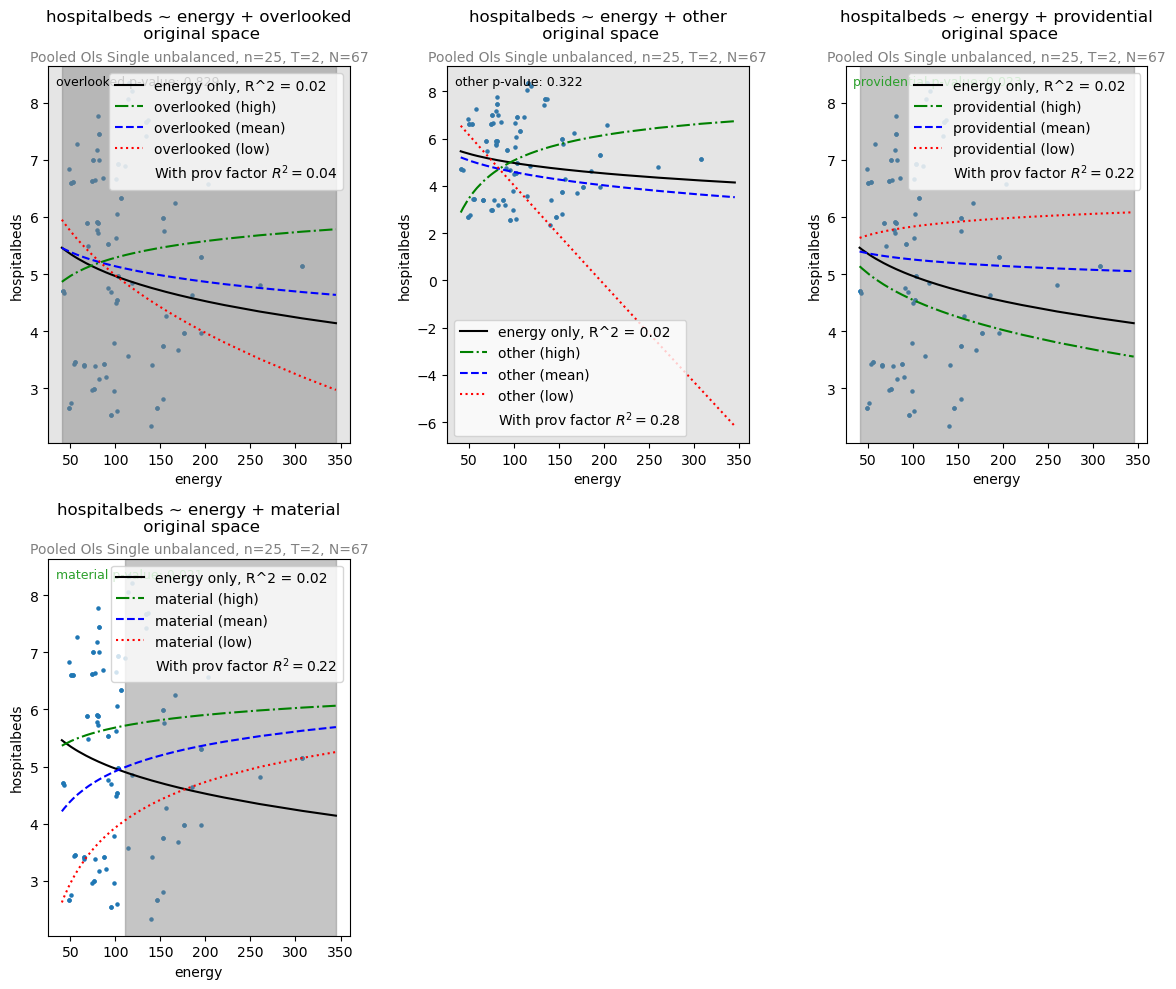

In [141]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_hospitalbeds, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

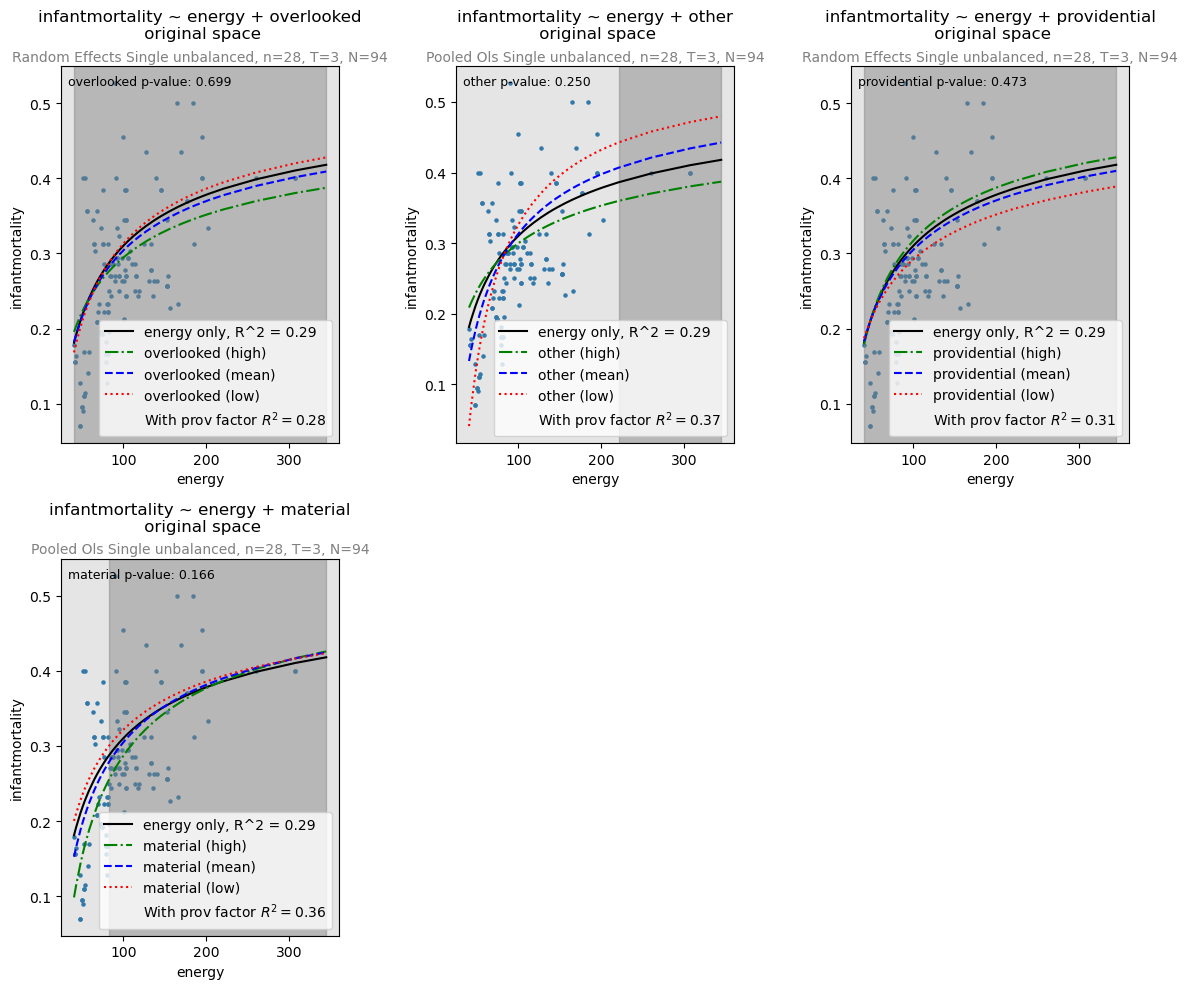

In [142]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_infantmortality, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

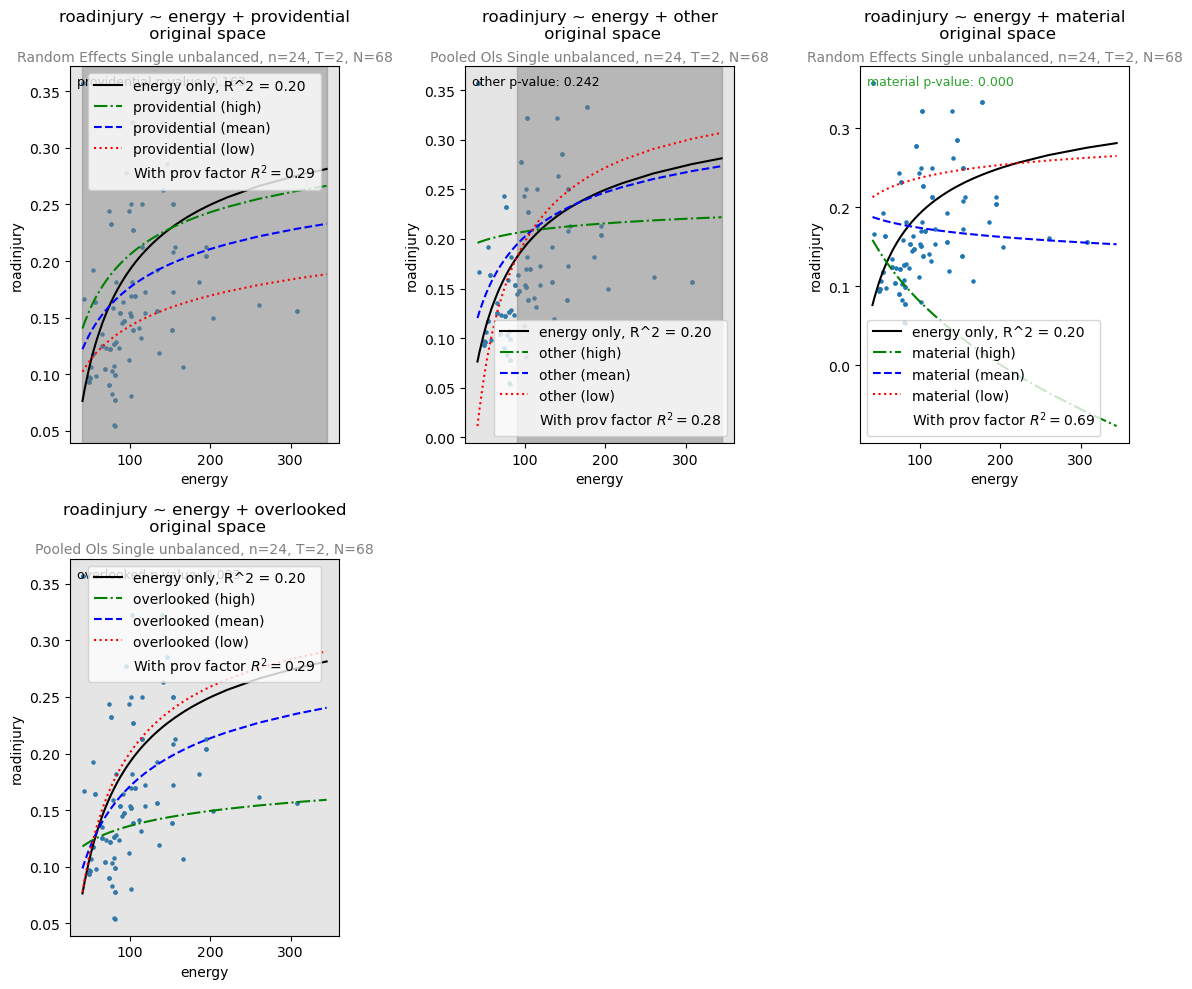

In [143]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_roadinjury, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

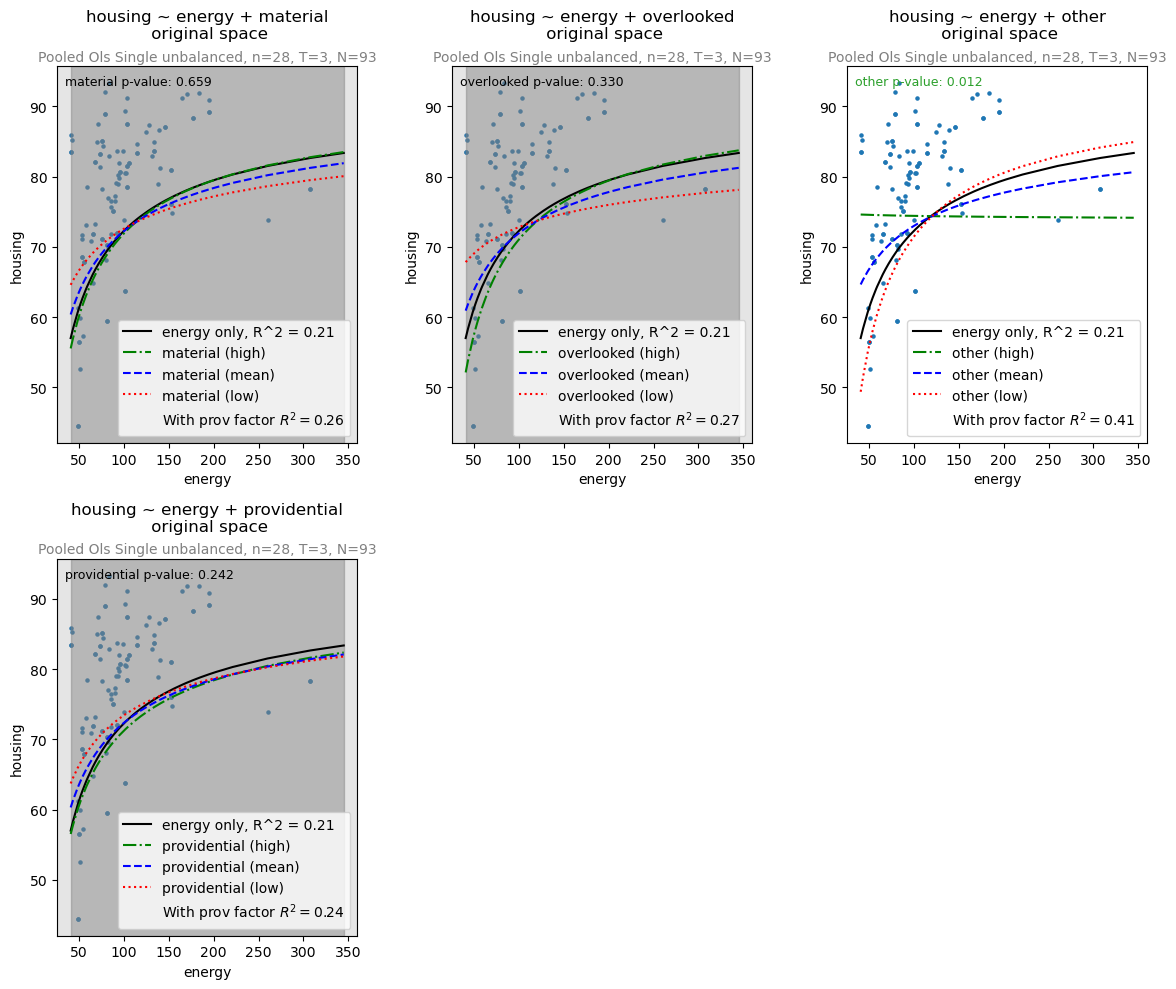

In [144]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_housing, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

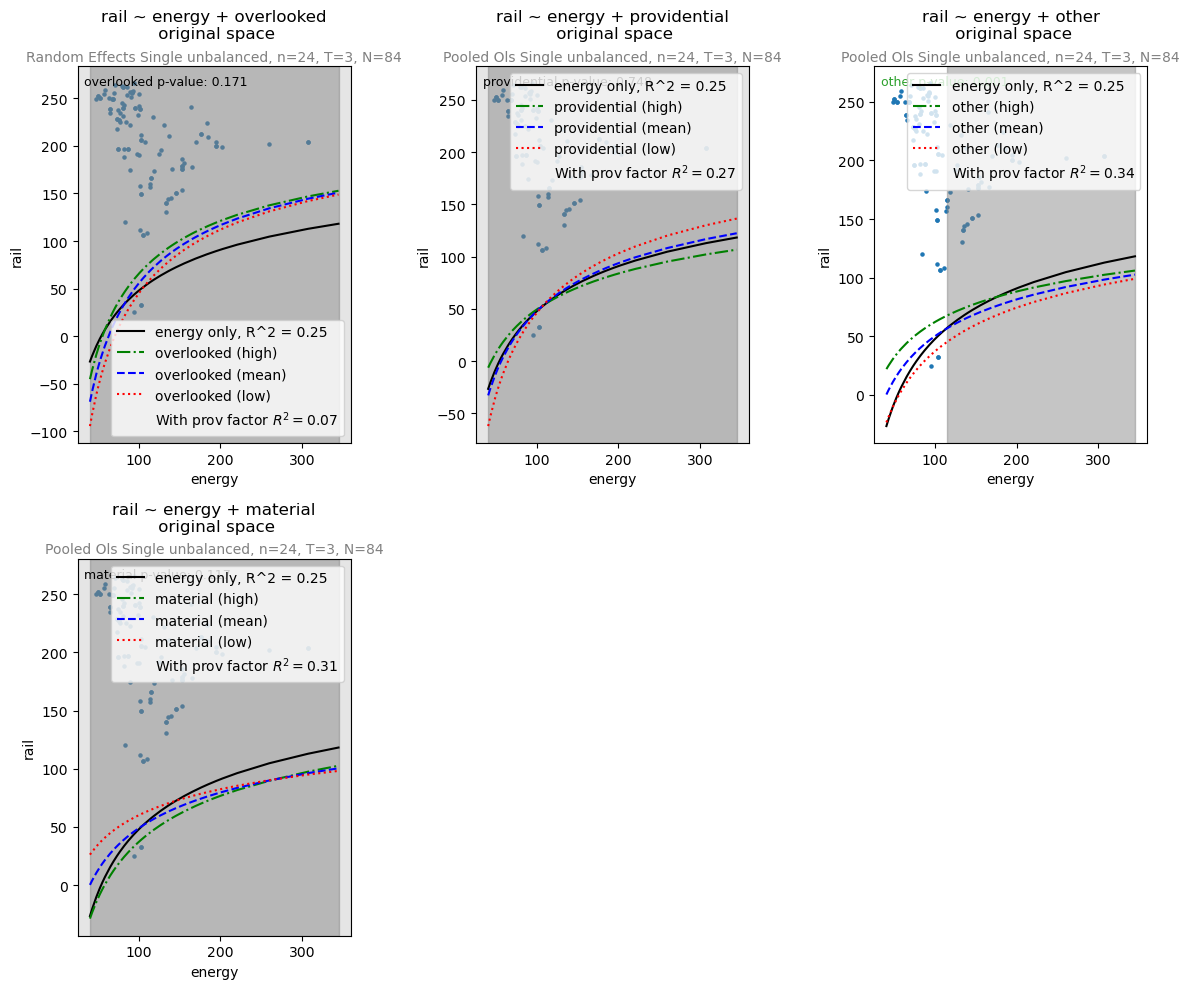

In [145]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_rail, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

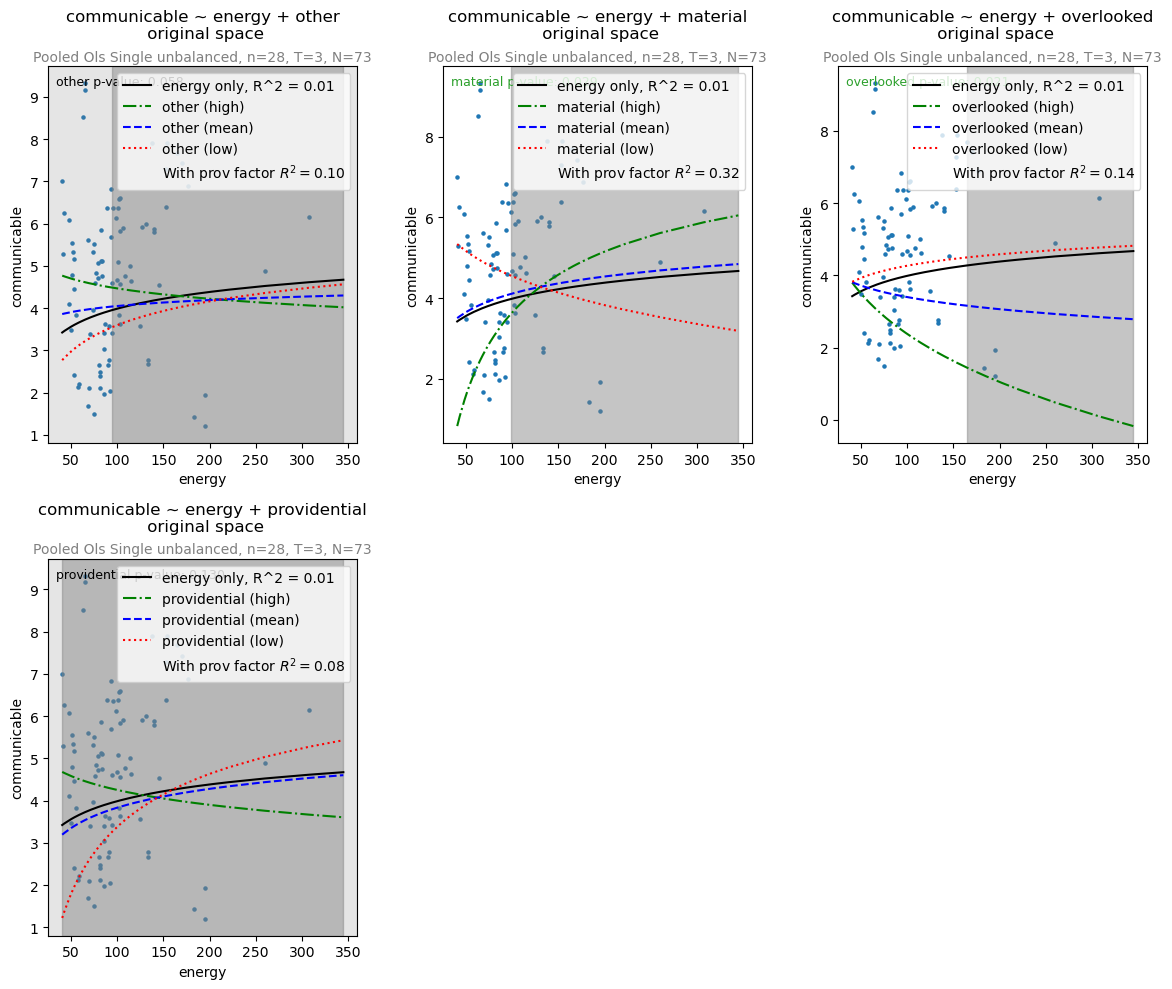

In [146]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_communicable, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

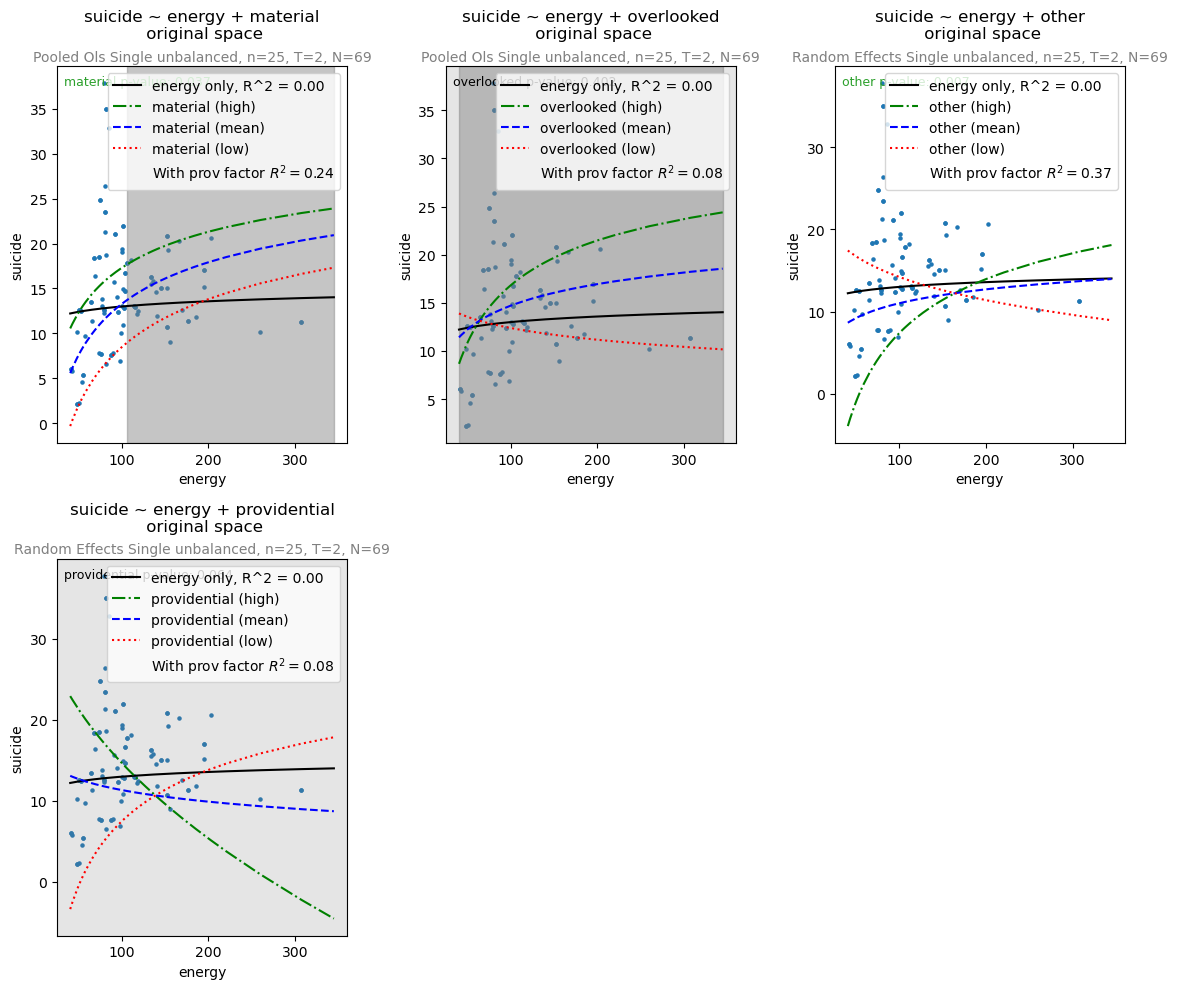

In [147]:
plot_regression_combinations(best_df_regressions_unbalanced, df_regressions_unique_combinations_suicide, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True, cols=3)

In [148]:
# plot_regression_combinations(best_df_regressions, df_regressions_unique_combinations, back_transformed_data, foundational_df_transformed, scaler_df, back_transform=True)

In [149]:
# plot_regression_combinations(best_df_regressions, df_regressions_unique_combinations, back_transformed_data, foundational_df_transformed, scaler_df, type='marginal_effects')

## EXIOBASE energy data, Labour Cost Survey labour shares (using this for the thesis)

In [150]:
# plot_regression_combinations(best_df_regressions_exiobase, df_regressions_exiobase_unique_combinations, back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, back_transform=True)

In [151]:
# plot_regression_combinations(best_df_regressions_exiobase, df_regressions_exiobase_unique_combinations, back_transformed_data_exiobase, foundational_df_transformed_exiobase, scaler_df_exiobase, type='marginal_effects')